# Step 1: Data Analysis & Dataset Sample

1.1 Data Acquisition

We use three publicly available fruit image datasets:

Fruits 360 (Kaggle) — studio-style, labeled .jpg images, 100×100, RGB, folder-per-class; provides separate Training/Test splits.
Link: https://www.kaggle.com/datasets/moltean/fruits

We selected this dataset because:

    - It includes a wide variety of fruit classes suitable for multi-class classification.

    - Images are already clean and labeled, minimizing preprocessing effort.

    - It is a well-known benchmark for fruit classification tasks.

    - The folder structure is compatible with PyTorch’s ImageFolder, making it easy to load.

Fruits Fresh & Rotten (Kaggle) — in-the-wild images; we use only the fresh* classes (e.g., freshapples, freshbanana, freshoranges, freshgrapes) and remap them to canonical labels (Apple, Banana, Orange, Grape) at load time.
Link: https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification

We include this dataset because:

    - It introduces real-world variation (backgrounds, lighting, angles) to test domain generalization beyond studio images.

    - It has overlapping classes with Fruits 360, enabling fair cross-dataset evaluation.

    - Using only fresh* keeps the label semantics aligned with Fruits 360 (which has no “rotten” class).

Fruit-262 (Kaggle) — contains additional classes missing from Fresh&Rotten (e.g., Kiwi, Avocado, Pineapple, Strawberry, Tomato). It ships without splits; we use the 104x128 subdirectory (closest to our 100×100 pipeline) and create our own splits.
Link: https://www.kaggle.com/datasets/aelchimminut/fruits262

    - We include this dataset because:

    - It extends class coverage for fruits not present in Fresh&Rotten’s fresh subset.

    - It provides additional natural variability, strengthening robustness tests.

    - Creating our own split supports reproducible experiments (fixed ratios and seed).

# 1.2 Dataset Reduction & Cleaning

To simulate a realistic, resource-constrained edge scenario, we reduce and standardize a focused subset of classes across all sources (Fruits 360, Fruits Fresh & Rotten — fresh-only, and Fruit-262). This lets us:
- Keep the task manageable
- Compare studio vs. real-world conditions  
- Run fair cross-dataset evaluations

## Scope & Rationale

**Focused label set:** Keep only overlapping or project-critical classes (e.g., Apple, Banana, Orange, Grape, plus Kiwi/Avocado/Pineapple from Fruit-262), so training/evaluation stay balanced and relevant.

**Canonical labels:** Source-specific names are mapped to a shared schema (e.g., `freshapples` → `Apple`) at load time; no physical folder renames.

## Per-Dataset Handling

**Fruits 360:**
- Use provided `Training/` and `Test/`
- Optionally carve a small validation split from `Training/` (e.g., 10%) for early stopping
- Keep `Test/` untouched for final reporting

**Fruits Fresh & Rotten (fresh-only):**
- Keep only the `fresh*` folders (e.g., `freshapples`, `freshbanana`, `freshoranges`, `freshgrapes`)
- Remap to canonical labels at load time to align semantics with Fruits 360

**Fruit-262:**
- Source has no split
- Use the `104x128` subdirectory (closest to our 100×100 pipeline)
- Create train/val/test = 80/10/10 with `seed=42` into `fruit262_split/`

## Cleaning & Standardization Steps (applied consistently)

1. **File integrity:** Drop unreadable/corrupt images (image open/verify)
2. **Size normalization:** Resize (or center-crop/pad, if needed) to 100×100 so all models receive uniform input
3. **Color handling:** 
   - Primary RGB pipeline
   - For edge deployment experiments, add grayscale variant (convert after resize for consistency)
4. **Label unification:** Apply canonical mapping at data loading time (e.g., `freshapples` → `Apple`), ensuring identical class IDs across sources
5. **Disjoint splits:** Ensure no file leaks across train/val/test; for generated splits (Fruit-262), fix `seed=42`
6. **Balancing** (optional but recommended): Mitigate domain/class imbalance by:
   - (a) Capping max images per (dataset, class) (e.g., 400), and/or
   - (b) Using weighted sampling/loss
7. **Metadata & reproducibility:** Record split ratios, seeds, class counts per split, and any caps applied (simple JSON log)

## Outcome

A unified, clean subset with:
- Standardized size (100×100)
- Consistent labels  
- Reproducible splits across Fruits 360, Fresh-only, and Fruit-262

Ready for:
- Fair training, validation (early stopping), and final testing
- Cross-dataset (domain generalization) evaluation

## 1.3 Exploratory Data Analysis (EDA)

**Goal.** Verify that the unified subset (Fruits 360, Fresh-only, Fruit-262) is consistent and fair, while explicitly accounting for **dataset-size differences**.

**Findings**
- **Fruits 360** has **fewer images per class** (≈200–220) than the other sources.
- Labels are unified via mapping (e.g., `freshapples → Apple`), so all loaders share the **same class IDs**.
- Native image sizes differ (Fruits 360: 100×100; Fruit-262: 104×128; Fresh-only: variable).

**Plan (deferred to Step 2: Preprocessing)**
- **Standardize image size** to **100×100** for all datasets.
- **Normalize per-class counts** by **subsampling the larger datasets** (Fresh-only and Fruit-262) down to ~**200 images per class** (seeded for reproducibility).  
  *We cap only the **training** portions; validation/test remain untouched.*
- We will also report **macro-F1** and per-class metrics so evaluation is not dominated by larger classes.


In [1]:
import os, sys, json
sys.path.append(os.path.abspath("../src"))

from data import (
    count_images_per_class,
    count_images_with_mapping,
    quick_image_sanity_check,
    split_imagefolder,
)
from viz import display_class_distribution
from utils import seed_everything, ensure_dir


In [2]:
seed_everything(42)

FR360_TRAIN_DIR = '../Dataset/Training'
FR360_TEST_DIR  = '../Dataset/Test'

FRESH_TRAIN_DIR = '../Dataset-hybrid/fresh_rotten/train'          # use only fresh* folders

F262_RAW_DIR    = '../Dataset-hybrid/fruit262_raw/104x128'        # source without split
F262_SPLIT_DIR  = '../Dataset-hybrid/fruit262_split'              # target with train/val/test

# ---- Output dirs
ensure_dir("../reports")
ensure_dir("../reports/figures")


[INFO] Global seed set to 42


WindowsPath('../reports/figures')


Fruits360 — Training Set Distribution
-------------------------------------
Apple Red 1: 492 images
Avocado 1: 427 images
Banana 1: 490 images
Kiwi 1: 466 images
Orange 1: 479 images
Pineapple 1: 490 images
Strawberry 1: 492 images
Tomato 1: 738 images


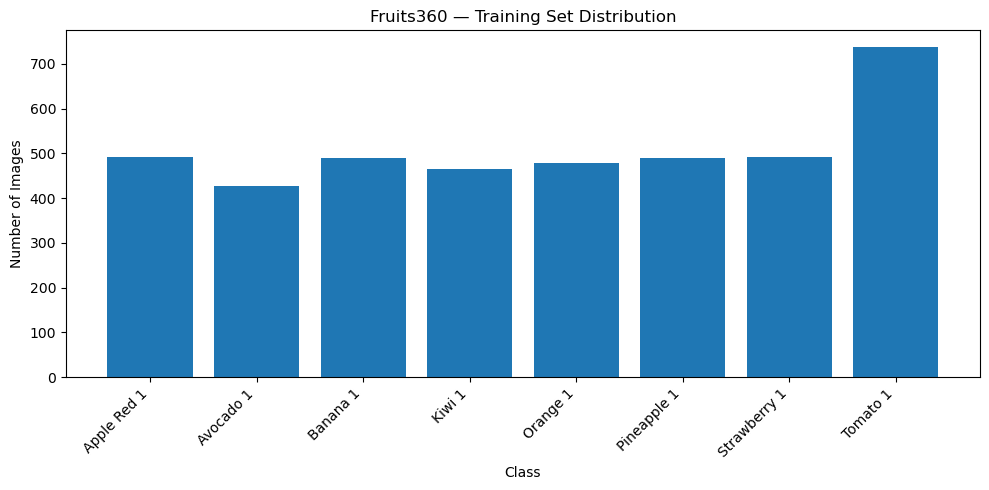


Fruits360 — Test Set Distribution
---------------------------------
Apple Red 1: 164 images
Avocado 1: 143 images
Banana 1: 166 images
Kiwi 1: 156 images
Orange 1: 160 images
Pineapple 1: 166 images
Strawberry 1: 164 images
Tomato 1: 246 images


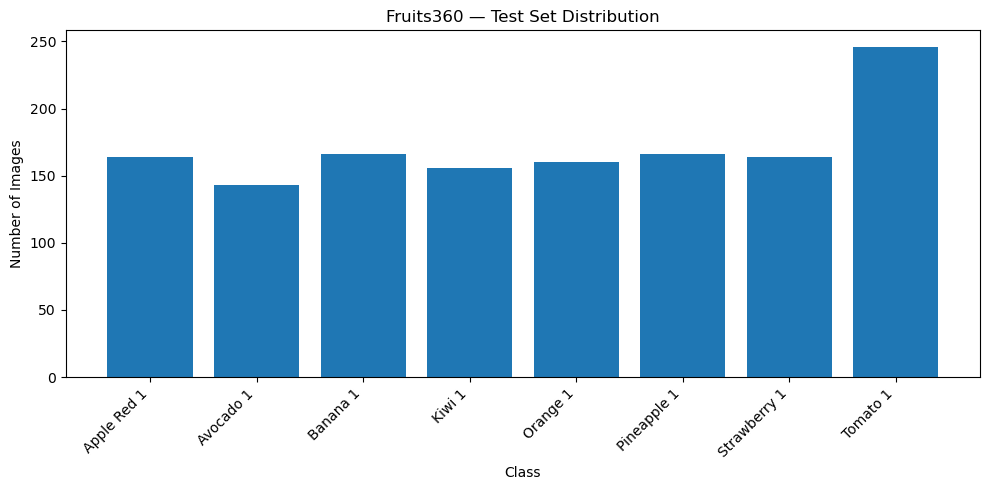

Fruits360 sanity mismatches (train): {'bad_size': 0, 'bad_mode': 0}
Fruits360 sanity mismatches (test):  {'bad_size': 0, 'bad_mode': 0}


In [3]:
# ==============================
# A) Fruits 360 — EDA
# ==============================
train_counts_360 = count_images_per_class(FR360_TRAIN_DIR)
test_counts_360  = count_images_per_class(FR360_TEST_DIR)

display_class_distribution(
    train_counts_360,
    title="Fruits360 — Training Set Distribution",
    save_path="../reports/figures/fruits360_train_distribution.png"
)
display_class_distribution(
    test_counts_360,
    title="Fruits360 — Test Set Distribution",
    save_path="../reports/figures/fruits360_test_distribution.png"
)

m_train_360 = quick_image_sanity_check(FR360_TRAIN_DIR, expect_size=(100, 100))
m_test_360  = quick_image_sanity_check(FR360_TEST_DIR,  expect_size=(100, 100))
print("Fruits360 sanity mismatches (train):", m_train_360)
print("Fruits360 sanity mismatches (test): ", m_test_360)



Fresh-only (mapped to canonical labels) — Distribution
------------------------------------------------------
Apple: 200 images
Banana: 200 images
Orange: 200 images


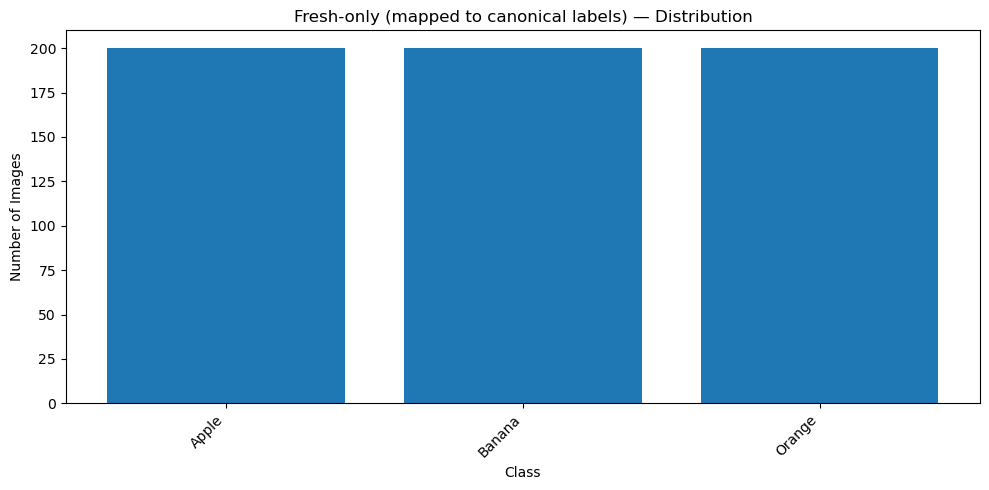

Fresh-only open/verify issues: {'bad_size': 0, 'bad_mode': 0}


In [4]:
# ==============================
# Fresh & Rotten (fresh-only) — EDA
# ==============================
FRESH_MAP = {
    "freshapples":  "Apple",
    "freshbanana":  "Banana",
    "freshoranges": "Orange",
}

fresh_counts = count_images_with_mapping(FRESH_TRAIN_DIR, FRESH_MAP)
display_class_distribution(
    fresh_counts,
    title="Fresh-only (mapped to canonical labels) — Distribution",
    save_path="../reports/figures/fresh_only_distribution.png"
)

# Fresh images are variable-sized; perform light open/verify only
m_fresh = quick_image_sanity_check(FRESH_TRAIN_DIR, expect_size=None)
print("Fresh-only open/verify issues:", m_fresh)



Fruit-262 (104x128) — Train Distribution
----------------------------------------
Avocado: 1121 images
Kiwi: 991 images
Pineapple: 1017 images
Strawberry: 990 images
Tomato: 994 images


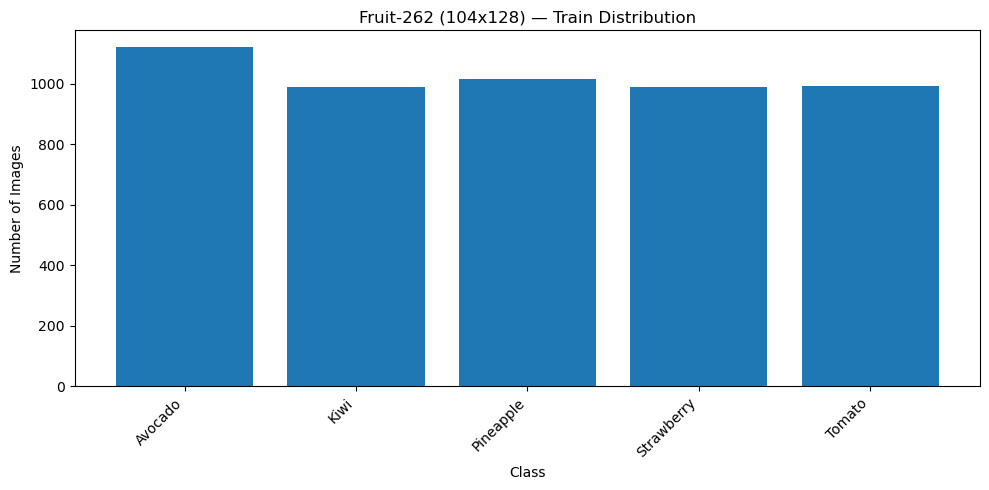


Fruit-262 (104x128) — Val Distribution
--------------------------------------
Avocado: 232 images
Kiwi: 202 images
Pineapple: 206 images
Strawberry: 200 images
Tomato: 200 images


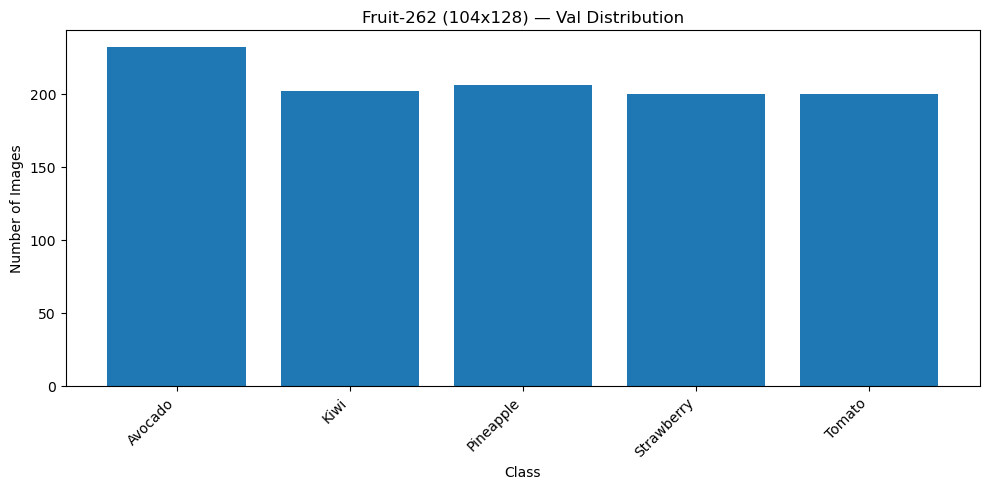


Fruit-262 (104x128) — Test Distribution
---------------------------------------
Avocado: 236 images
Kiwi: 202 images
Pineapple: 210 images
Strawberry: 202 images
Tomato: 200 images


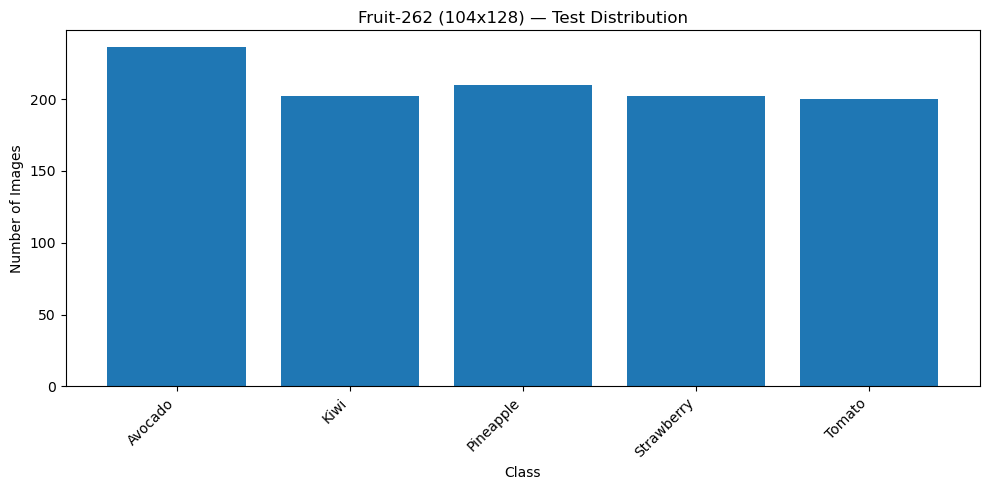

Fruit-262 sanity (train): {'bad_size': 0, 'bad_mode': 0}
Fruit-262 sanity (test):  {'bad_size': 0, 'bad_mode': 0}


In [5]:
# ==============================
# C) Fruit-262 — create split if missing + EDA
# ==============================
F262_MAP = {
    "avocado":    "Avocado",
    "kiwi":       "Kiwi",
    "pineapple":  "Pineapple",
    "strawberry": "Strawberry",
    "tomato":     "Tomato",
}

# Build deterministic split once (80/10/10, seed=42)
stats_262 = split_imagefolder(
    src_root=F262_RAW_DIR,
    dst_root=F262_SPLIT_DIR,
    classes_raw_to_canon=F262_MAP,
    ratios=(0.8, 0.1, 0.1),
    seed=42,
    check_images=True
)

# Counts per split
f262_train_counts = count_images_per_class(os.path.join(F262_SPLIT_DIR, "train"))
f262_val_counts   = count_images_per_class(os.path.join(F262_SPLIT_DIR, "val"))
f262_test_counts  = count_images_per_class(os.path.join(F262_SPLIT_DIR, "test"))

display_class_distribution(
    f262_train_counts,
    title="Fruit-262 (104x128) — Train Distribution",
    save_path="../reports/figures/fruit262_train_distribution.png"
)
display_class_distribution(
    f262_val_counts,
    title="Fruit-262 (104x128) — Val Distribution",
    save_path="../reports/figures/fruit262_val_distribution.png"
)
display_class_distribution(
    f262_test_counts,
    title="Fruit-262 (104x128) — Test Distribution",
    save_path="../reports/figures/fruit262_test_distribution.png"
)

# Fruit-262 images are variable-sized; light open/verify only
m_f262_tr = quick_image_sanity_check(os.path.join(F262_SPLIT_DIR, "train"), expect_size=None)
m_f262_te = quick_image_sanity_check(os.path.join(F262_SPLIT_DIR, "test"),  expect_size=None)
print("Fruit-262 sanity (train):", m_f262_tr)
print("Fruit-262 sanity (test): ", m_f262_te)

In [6]:
# ==============================
# D) Persist compact EDA summary
# ==============================
eda_summary = {
    "fruits360": {
        "train_total": sum(train_counts_360.values()),
        "test_total":  sum(test_counts_360.values()),
        "n_train_classes": len(train_counts_360),
        "n_test_classes":  len(test_counts_360),
    },
    "fresh_only": {
        "train_total": sum(fresh_counts.values()),
        "n_train_classes": len(fresh_counts),
        "mapping_used": FRESH_MAP,
    },
    "fruit262": {
        "split_stats": stats_262,
        "train_total": sum(f262_train_counts.values()),
        "val_total":   sum(f262_val_counts.values()),
        "test_total":  sum(f262_test_counts.values()),
        "n_classes":   len(set().union(f262_train_counts, f262_val_counts, f262_test_counts)),
    }
}
with open("../reports/eda_summary.json", "w") as f:
    json.dump(eda_summary, f, indent=2)
print("EDA summary saved → reports/eda_summary.json")

EDA summary saved → reports/eda_summary.json
